<center><h1>Statistics for Machine Learning</h1></center>
&nbsp;
<center><h2>Pearson's Correlation Coefficient and R Squared</h2></center>

### Overview

This notebook introduces the Pearson Product-Moment Correlation Coefficient (PPMCC), often simply referred to as the Correlation Coefficient or $\rho$. This is a measure of the strength of the relationship between two variables in bivariate data, bounded between -1 and 1. The square of this value, the Coefficient of Determination, is also introduced and explained. $p$-Values are then used to quantify the confidence in the results. The equations for calculating these values are derived and examples are illustrated using the SOCR Heights and Weights dataset from UCLA [1].

### Pre-requisites

This notebook builds on *Covariance and the Covariance Matrix*, taking the ideas of covariance and using them to calculated a bounded value to describe the relation between two variables. Additionally, the idea of variance and standard deviation are also used, which are described in more detail in *Population Parameters for Normal Distributions*.

### Contents

Section 1 - Introduction to Correlation

Section 2 - Equations and Interpretation

Section 3 - Calculating Correlation with SciPy

Section 4 - Conclusion

Section 5 - Glossary

Section 6 - References

### Loading the Data

The SOCR dataset from UCLA contains height and weight information for 25,000 18 year olds, who form the population for this notebook [2].

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('datasets/SOCR-HeightWeight.csv', sep=',')
heights = list(df['Height(Inches)'])
weights = list(df['Weight(Pounds)'])

print(f'Number of rows: {len(df)}')

Number of rows: 25000


<center><h2>Section 1 - Introduction to Correlation</h2></center>

### 1.1 - Motivation for the Correlation Coefficient

As shown in *Covariance and the Covariance Matrix*, the covariance is a measure for the degree that two variables vary together. The value of the covariance is unbounded, and so can range from -$\infin$ to $\infin$. As described previously, this property does not make the covariance much of a useful measure, outside of telling us whether there is a positive trend or negative trend in the data (or if there is no trend for values close to 0).

The **correlation coefficient**, $\rho$, bounds the covariance value between -1 and 1, where -1 represents a perfectly negative trend and 1 represents a perfectly positive trend. As before, a value of 0 represents no trend in the data. The term *perfectly* describes a graph in which a straight line can be drawn through every $x$-$y$ point with no point deviating from the line. In reality, such results from experiments are rare due to random noise in the measurements.

For emphasis:
> The main goal of the correlation coefficient is to quanitify the strength of a relationship between two variables with a value between -1 and 1. Positive values indicate positive relationships, negative values indicate negative relationships, and values close to 0 indicate no relationship.

### 1.2 - Graphs of Example Correlation Values

Below are a set of graphs for data with different correlation values. Unlike covariance, it is quite simple to guess an approximate value for correlation, just by looking at a graph. Each plot below shows a relationship which ranges from no trend ($\rho$=0) to perfect trend ($\rho$=-1 or $\rho$=1). The values used here include:

* $\rho$ = -1 (perfectly negative correlation)

* $\rho$ = -0.7 (strong negative correlation)

* $\rho$ = -0.3 (weak negative correlation)

* $\rho$ = 0 (no correlation)

* $\rho$ = 0.3 (weak positive correlation)

* $\rho$ = 0.7 (strong positive correlation)

* $\rho$ = 1 (perfectly positive correlation)

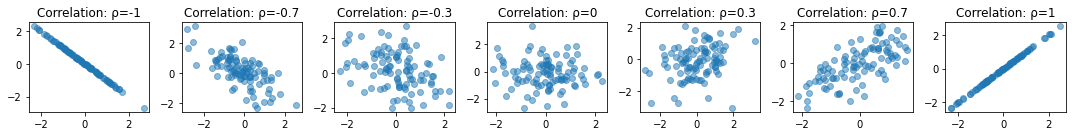

In [5]:
covariances = [-1, -0.7, -0.3, 0, 0.3, 0.7, 1]

fig, ax = plt.subplots(ncols=7, figsize=(15,2))

for col, cov in enumerate(covariances):
    covariance_matrix = [[1, cov],
                        [cov, 1]]
    data = np.random.multivariate_normal([0,0], covariance_matrix, size=100)
    ax[col].set_title(f'Correlation: \u03C1={cov}')
    ax[col].scatter(data[:,0], data[:,1], alpha=0.5)

fig.tight_layout()

### 1.3 - Plotting the SOCR Heights and Weights Data

Using the plots above as a guide, we can already begin to estimate a rough value for the correlation coeffcient of the SOCR Heights and Weights data. This will be calculated exactly later in the notebook, but for now it is helpful to see the shape of the data.

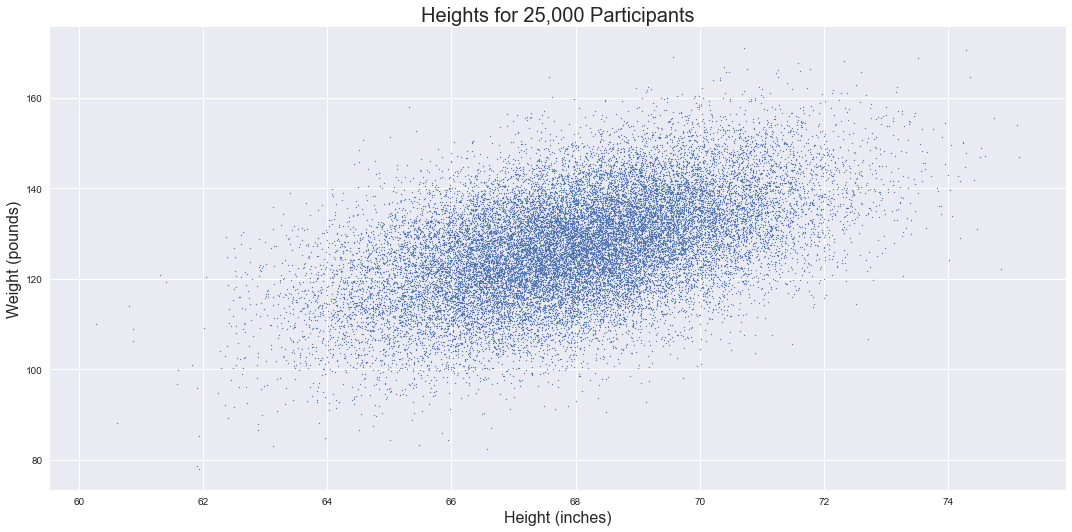

In [14]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(15,7.5))

ax.set_title('Heights for 25,000 Participants', fontsize=20)
ax.scatter(heights, weights, s=1)
ax.set_xlabel('Height (inches)', fontsize=16)
ax.set_ylabel('Weight (pounds)', fontsize=16)

fig.tight_layout()

### 1.4 - Correlation and Linear Relationships

The Pearson Correlation Coefficient (the quantity described in this notebook) is only valid for linear relationships. That is, bivariate data where the trend can be summarised by a straight line. For non-linear relationships (such as polynomials) another measure exists to determine the correlation. This is called the Spearman's Rank Correlation Coefficient, $rs$, and is covered in the notebook *Spearman's Rank Correlation*. This notebook will focus on linear relationships in bivariate data.

### 1.5 - Correlation and Causation

Correlation gives a measure of how strong the relationship is between two variables. For example, the number of ice creams sold per day and the number of people who having boating accidents. There might be a very strong correlation between these two variables, and so we could use information about one to predict the other. However, correlation does not mean that one of the variables *causes* the other - only that they are related.

In this example, the fact the weather is sunny could cause people to buy more ice cream, and also encourage people to take out their boats. The more boats, the more likely an accident is to occur. But we could not know this just from data about ice cream sales and boating accidents alone. So it is important not to confuse correlation and causation. The two are related but very different.

<center><h2>Section 2 - Equations and Interpretation</h2></center>

### 2.1 - Pearson's Correlation Coefficient, $\rho$

The purpose of the correlation coefficient is to bound the covariance value between -1 and 1. To do this, we need to normalise the covariance using some value. Due to the differences between calculating population parameters and sample parameters (as described in *Sampling a Distribution & Bessel's Correction*), the value used for the population and sample correlation coefficients are slightly different. Both equations are presented below.

&nbsp;

$
\rho_\text{X,Y} = \frac{Cov(X,Y)}{\sigma_A \sigma_B} \tag{Population}
$

&nbsp;

$
r_\text{X,Y} = \frac{Cov(X,Y)}{s_X s_Y} \tag{Sample}
$ 

&nbsp;

where $\sigma_X$ and $\sigma_Y$ are the population standard deviations, and $s_X$ and $s_Y$ are the sample standard deviations.

&nbsp;


### 2.2 - Coefficient of Determination, $R^2$

The correlation coefficient can be squared to give another useful quantity: the **Coefficient of Determination**, $R^2$. This value represents the proportion of the variation in $Y$ that can be explained because of the variation in $X$. (Note that since it doesn't matter which axes the variables are plotted on, the $R^2$ value also represents the proportion of the variation in $X$ that can be explained because of the variation in $Y$).

For example, if $X$ and $Y$ are perfectly correlated ($\rho$=-1 or $\rho$=1), $R^2$ would also be 1. This is because any change in the value of $x$ gives a directly proportional change in the value of $y$, with no random noise. Later the $\rho$ and $R^2$ values for the SOCR heights and weights data will be found. The correlation value is not perfectly 1, and so the $R^2$ value is between 0 and 1. This means that some fraction of the height is responsible for explaning the weight of a person. The remaining fraction is due to other factors (genetics, diet, exercise etc).

&nbsp;

### 2.3 Recap of the Differences between $\rho$ and $R^2$

$\rho$ and $r$:

* Bounded between -1 and 1

* Describes the strength and type of a relationship (positive, negative or no relationship)

* Calculated using an equation

&nbsp;

$R^2$

* Bounded between 0 and 1

* Describes the proportion of variance in a variable that explained by another variable

* Calculated by squaring $\rho$ (population) or $r$ (sample)

&nbsp;


### 2.4 - Understanding the Equations

The equation for calculating the correlation coefficient can be explained more easily if it is rewritten slightly:

&nbsp;

$
\rho_\text{X,Y} = \frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}} \tag{1}
$

&nbsp;

$
=\frac{\frac{\sum  \limits _{i=1}^{N} (x_i - \mu_x)(y_i - \mu_y)}{N}}{\sqrt{\frac{\sum  \limits _{i=1}^{N} (x_i - \mu_x)^2}{N}\frac{\sum  \limits _{i=1}^{N} (y_i - \mu_y)^2}{N}}} \tag{2}
$

&nbsp;

$
=\frac{\sum  \limits _{i=1}^{N} (x_i - \mu_x)(y_i - \mu_y)}{\sqrt{\sum  \limits _{i=1}^{N} (x_i - \mu_x)^2\sum  \limits _{i=1}^{N} (y_i - \mu_y)^2}} \tag{3}
$

&nbsp;

Hence $R^2$ can be written as:

&nbsp;

$
R^2=\frac{\big(\sum  \limits _{i=1}^{N} (x_i - \mu_x)(y_i - \mu_y)\big)^2}{\sum  \limits _{i=1}^{N} (x_i - \mu_x)^2\sum  \limits _{i=1}^{N} (y_i - \mu_y)^2} \tag{3}
$

&nbsp;


In these forms it is clearer to see the mechanisms behind the equations. The numerators take the product of the differences in $x$ and $y$ about the respective means. In mathematics, the term *moment* can be used to describe many quantities - but in statistics this refers to the mean of data. Since the numerators contain the product of distances from the mean, these quantities can be called the *product moment*, and so $\rho$ is also called the *Pearson's Product Moment Correlation Coefficient*.

If the numerator is finding the degree to which the variables vary together, the denominator is finding the degree of variation in each variable separately. In the case of $R^2$ the variance values are used in the equation directly (note that division by $N$ cancels out). This means that the coefficient of determination gives a ratio of how much the variables vary together, to how much the variables vary separately. In other words, the *proportion* of the total variance in the measurements that can be *explained* by the covariance.

In the case of $\rho$ and $r$, the square root in the denominator is used to keep $\rho$ scaled appropriately. Since the numerator contains $(x_i - \mu_x)$ and $(y_i - \mu_y)$ only once each, there must be exactly one $(x_i - \mu_x)$ and one $(y_i - \mu_y)$ term in the numerator. This ensures an equal comparison of $X$ and $Y$ between the numerator and denominator.

### 2.5 - Interpreting $\rho$ and $R^2$

Since $\rho$ is dependent on the square root of the variance, the interpretation of the value is not immediately intuitive. For example, a $\rho$ value of 0.7 represents a dataset where the relationship is twice as strong as one where $\rho$ is 0.5. However, since $R^2$ is using the variance directly, the interpretation of the value IS immediately intuitive. An $R^2$ value of 0.7 represents a dataset where the relationship is 1.4 times stronger than one where $R^2$ is 0.5. For this reason, $R^2$ is a very useful metric.


The question then becomes 'why not only use $R^2$'? The answer is because $R^2$ is bounded between 0 and 1, not -1 and 1, and cannot describe is a relationship is positive or negative.

### 2.6 - $p$-Values for Correlation

Every correlation test should produce three values:

* a correlation coefficient, $\rho$ or $r$
* a coefficient of determination, $R^2$
* a $p$-value

The **$p$-value** gives a measure of the confidence in the correlation coefficent, and takes a value between 0 and 1. The correlation coefficient describes how the points in the dataset deviate from a line of best fit. But if there are not that many points in the dataset, we cannot be very confident that the $r$ value is correct. Maybe the rest of the data we havent sampled is very far from the line, but we have just happened to sample some points that make a very good fit. Or maybe we have taken a particularly bad sample, and the rest of the points we havent measured do not deivate much from the line at all. Clearly the amount of confidence we can have in the correlation coefficient is dependent on the number of samples we have taken - this is captured in the $p$-value.

> The $p$-value is the probability that random chance could have generated data with the same correlation value or higher.

If the $p$-value is very low, then there is a very small chance that sampling random data would have produced the point we have measured, and the sample points just happen to look like they form a trend. For low values like this we can have very high confidence that the trend is representative of the entire dataset. If the $p$-value is very high, then it is probable that sampling random points would have produced similar data, and so we cannot have much confidence in any correlation value or trend that is predicted.


### 2.7 - Confidence vs Accuracy of Predictions

It is important to note that $r$ and the $p$-value are two different quantities. The $r$ value gives a measure of how related two variables are. The closer the relation to 1 or -1, the more accurately we will be able to predict the value of one variable given the value of the other. The $p$-value gives a measure of the confidence in how good $r$ is at describing the entire population data, not just the small sample that has been collected.

It is very possible to record a high $r$ value near 1, but have low confidence in the value. In the case where only two measurements are made for a sample, the correlation value will be 1 because you can always draw a straight line value between two points. The $p$-value will also be 1, because this indicates that any combination of points would have given an $r$ value of 1, so we cannot be confident at all that the line we have drawn is representative of the entire population.

Conversely, it is also possible to have a very low correlation coefficient, but have extremely high confidence in it (the $p$-value is very close to 0). This result means that enough data was collected to be confident in the conclusion, but the conclusion is that the relationship between the variables is very weak. Hence, predictions about one variable using the other will have a high degree of error associated with them.

### 2.8 - Calculating the $p$-Value

The $p$-value requires a fairly complex series of equations to compute, and is beyond the scope of this notebook - perhaps to be covered another time. However, since the goal of these notebooks to is understand every equation along the way, it is important to point to a resource that covers the topic even if this one does not. At this point it is useful to consult the SciPy documentation which is described and reference in the section below. This gives an overview of the beta function used to determine this value.

Note that the $p$-value is rarely, if ever, calculated by hand and so computational means are the standard way to determine this value.

<center><h2>Section 3 - Calculating Correlation with SciPy</h2></center>

### 3.1 - The SciPy `pearsonr` Function

SciPy is a scientific Python library that offers many tools for scientific calculation with Python. The statistics module in particular has many useful tools, one of which is the `scipy.stats.pearsonr` function [3]. This takes in two array-like inputs representing the data for two different variables, and returns an $r$ value and a two-sided $p$-value for the confidence in the prediction. It is assumed that the data follow a Normal distribution. The SciPy documentation states:

> The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets

To obtain the coefficient of determination, the correlation coefficient can simply be squared.

### 3.2 - Calculating the Correlation of the SOCR Heights and Weights Data

To use the `pearsonr` function is straightforward, and can be implemented with a single line of code. Below shows a simple example using the SOCR Heights and Weights dataset. The values for $r$, $R^2$ and the $p$-value are all calculated and presented.

In [6]:
r, p_value = st.pearsonr(heights, weights)
R_squared = r**2

print(f'Correlation Coefficient     : {r:.2f}')
print(f'Coefficient of Determination: {R_squared:.2f}')
print(f'p-Value                     : {p_value}')

Correlation Coefficient     : 0.50
Coefficient of Determination: 0.25
p-Value                     : 0.0


### 3.3 - Plotting the Line of Best Fit

The theory behind plotting this line will be covered in the notebook *Least Squares and Linear Regression*. For now however, the techniques will simply be applied to plot the line of best fit, with the focus instead on gaining an intuition of the results of the Pearson Correlation test.

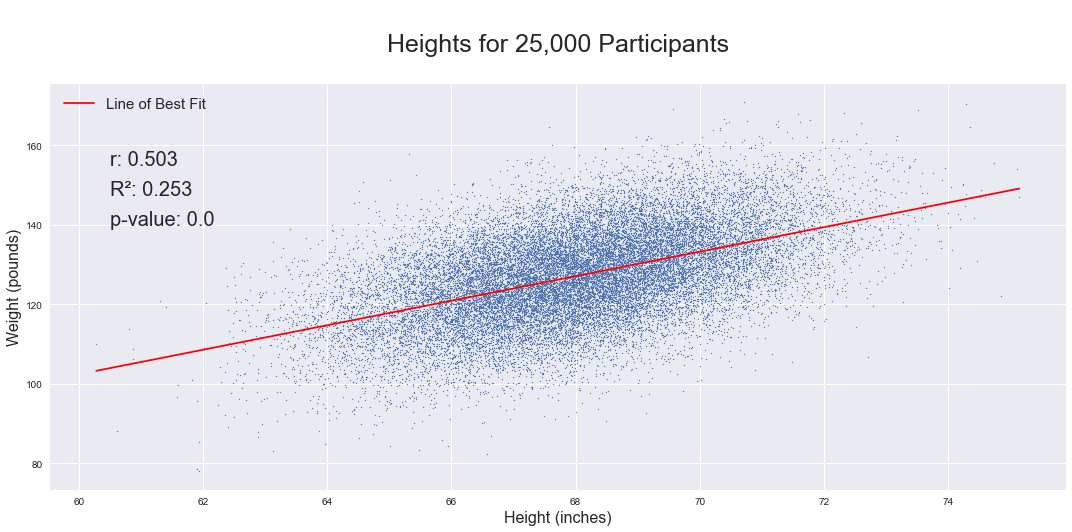

In [47]:
# Get line of best fit
reg_heights = [[height] for height in heights]
reg_weights = [[weight] for weight in weights]

reg = LinearRegression().fit(reg_heights, reg_weights)
reg.score(reg_heights, reg_weights)

x_values = [min(heights), max(heights)]
y_values = [((reg.coef_*x)+reg.intercept_)[0] for x in x_values]


# Plot graph
fig, ax = plt.subplots(figsize=(15,7.5))

ax.set_title('\nHeights for 25,000 Participants\n', fontsize=25)
ax.scatter(heights, weights, s=1)
ax.plot(x_values, y_values, color='red', label='Line of Best Fit')
ax.set_xlabel('Height (inches)', fontsize=16)
ax.set_ylabel('Weight (pounds)', fontsize=16)

ax.annotate(text=f'r: {r:.3f}', xy=[60.5,155], fontsize=20)
ax.annotate(text=f'R\u00B2: {R_squared:.3f}', xy=[60.5,147.5], fontsize=20)
ax.annotate(text=f'p-value: {p_value}', xy=[60.5,140], fontsize=20)

ax.legend(fontsize=15)

fig.tight_layout()



### 3.4 - Interpreting the Results

In this dataset, the correlation coefficient was found to be 0.503 (3 s.f), which is a moderately strong correlation. The coefficient of determination was 0.253 (3 s.f.) indicating that around 25.3% of someone's weight could be explained by their height, and vice versa. Finally the $p$-value was vanishingly small due to the number of samples being so high (25,000), and so the value was rounded to zero.

The results of this experiment match expectations. Heights and weights can be expected to have a positive relationship, since and increase in height should correspond to some increase in weight. This is confirmed by the positive, non-zero correlation coefficient. The low value for the coefficient of determination seems very reasonable, since there is a large amount of spread in the data. This highlights that around 75% of someones weight is attributed to factors other than their height, such as genetics and lifestyle choices. A low $p$-value means that there is a very small chance that 25,000 random samples would have produced a correlation with this value or higher, and so we can be very confident in the $r$ that was reported.

<center><h2>Section 4 - Conclusion</h2></center>

Pearson's Correlation Coefficient, $\rho$ or $r$, can be used to quanitify the strength of the relationship in bivariate data. The value lies between -1 and 1, with negative values indicating negative correlation and positive values indicating positive correlation. Values close to 0 represent no connection between the variables. The square of this value is the Coefficient of Determination, $R^2$. This gives the proportion of the variance in one variable that can be explaned by the variance in the other. A value of 1 represents two variables that are perfectly correlated, and a value of 0 represents independent variables. Finally, a $p$-Value can be used to quanitify the confidence in the Correlation Coefficient. This takes a value between 0 and 1 and represents the probability that random chance could have produced a similarly strong correlation or stronger. Low $p$-Values represent a high confidence in the Correlation Coefficient.

<center><h2>Section 5 - Glossary</h2></center>

**Correlation Coefficient**
> A measure of the strength of the relationship between two variables, bounded between -1 and 1, where positive values represent a positive relationship and negative values represent a negative relationship

**Coefficient of Determination**
> The square of the Correlation Coefficient, represents the proportion of the variance of one variable that can be explained by the variance of the other

**$p$-Value**
> The $p$-value is the probability that random chance could have generated data with the same correlation value or higher.

<center><h2>Section 6 - References</h2></center>

[1] SOCR Heights and Weights dataset - [UCLA](http://socr.ucla.edu/docs/resources/SOCR_Data/SOCR_Data_Dinov_020108_HeightsWeights.html)

[2] Dataset download - [Kaggle](https://www.kaggle.com/burnoutminer/heights-and-weights-dataset/version/1)

[3] SciPy `pearsonr` Function - [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)